In [12]:
from _tests import scripts
from scripts.notebook_utils import *

In [40]:
ARCH_PATH = "/home/workspace/models/arch/1_macro/dummy/arch.yaml"

def run_basic_analog_spec(array_rows: int, array_columns: int):
    # Load in the specification
    spec = get_spec("dummy")

    # Enable the MAX_UTILIZATION variable. This will generate a
    # workload that maximizes the utilization of the array.
    spec.variables["MAX_UTILIZATION"] = True

    # Set the number of rows and columns in the array
    #spec.architecture.find("weight_modulators").attributes.n_instances = 24
    spec.architecture.find("IMU").spatial.meshX = 1
    spec.architecture.find("input_modulator").spatial.meshY = array_rows

    return run_mapper_parse_output(spec, "my_spec")


results = run_basic_analog_spec(array_rows=24, array_columns=24)
print(f"Total Energy (pJ): {results.total_energy:.2f}")
print(f"Total Area (mm^2): {results.total_area / 1000000:.2f}")
print(f"Number of MACs: {results.macs:.2f}")
print(f"Compute Density (TOPS/mm^2): {results.tops_per_mm2:.2f}")
print(f"Energy Efficiency (TOPS/W): {results.tops_per_w:.2f}")

Total Energy (pJ): 1080.90
Total Area (mm^2): 1862.08
Number of MACs: 576.00
Compute Density (TOPS/mm^2): 0.00
Energy Efficiency (TOPS/W): 1.07


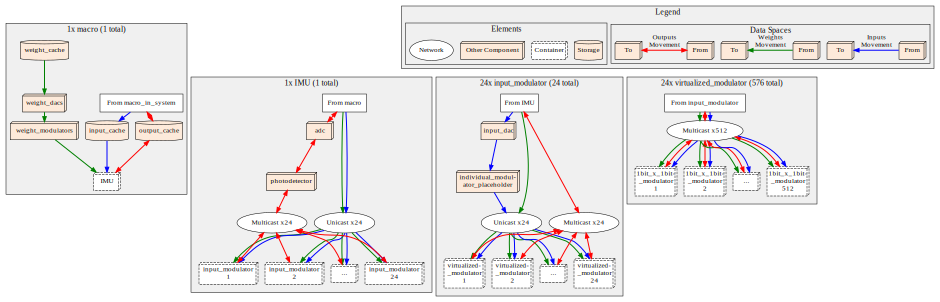

In [41]:
display_diagram(get_diagram("dummy", ["macro", "IMU", "input_modulator", "virtualized_modulator"]))